In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# from dataprep.eda import create_report, plot, plot_correlation, plot_missing, plot_diff

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from nltk.corpus import names
import nltk
import random

#-----------------------------------------------------------------------------------------
# FEATURE GENERATION: GENDER
#-----------------------------------------------------------------------------------------

def gender_features(word):
    return {'last_letter':word[-1]}
  
# preparing a list of examples and corresponding class labels.
labeled_names = ([(name, 'male') for name in names.words('male.txt')]+
             [(name, 'female') for name in names.words('female.txt')])
  
random.shuffle(labeled_names)
  
# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) 
               for (n, gender)in labeled_names]
  
# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = featuresets[500:], featuresets[:500]
  
# The training set is used to 
# train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(train_set)
  
    
def get_gender(name):
    return classifier.classify(gender_features(name))

In [3]:
#-----------------------------------------------------------------------------------------
# FEATURE IMPORTANCE
#-----------------------------------------------------------------------------------------

def plot_feature_importance (estimator_object, X_train, y_train):

    model = estimator_object
    model.fit(X_train, y_train)  


    feature_importance = model.feature_importances_

    # Make importance relative to max_importance

    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(8, 18))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.keys()[sorted_idx])  #!!!!!

    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

    plt.show()

In [4]:
#---------------------------------------------------------------------------------------------
# Target encoding done the right way
# https://maxhalford.github.io/blog/target-encoding/
#---------------------------------------------------------------------------------------------

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

def calc_smooth_mean_for_column(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    return (counts * means + m * mean) / (counts + m)


In [3]:
train_df = pd.read_csv('~/TestProj/ML/Spaceship_Titanic/Data/train.csv')
test_df  = pd.read_csv('~/TestProj/ML/Spaceship_Titanic/Data/test.csv')

transported = train_df['Transported']
transported = transported.apply(lambda r: 1 if r else 0)

train_df['Transported'] = train_df['Transported'].apply(lambda r: 1 if r else 0)

all_dataframes = [train_df, test_df]

for df in all_dataframes:
    df['CryoSleep']   = df['CryoSleep'].apply(lambda r: 1 if r else 0)
    df['VIP']         = df['VIP'].apply(lambda r: 1 if r else 0)
    
    

submission_df = pd.DataFrame(test_df.loc[:, 'PassengerId'])

# train_df.drop(['Transported'], axis = 1, inplace=True)

In [4]:
for df in all_dataframes:
    
#   PassengerId - Уникальный идентификатор для каждого пассажира. 
#     Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, 
#     с которой путешествует пассажир, а pp — его номер в группе
    
    df['PassengerGroup'] = df['PassengerId'].apply(lambda r: r[:4])
    df['NumberInGroup']  = df['PassengerId'].apply(lambda r: r[-2:])
    
#   Cabin - Номер каюты, в которой находится пассажир. 
#     Принимает форму палуба/число/сторона, где сторона может быть либо P для левого борта, 
#     либо S для правого борта.  
    
    df['CabinDesk'] = df['Cabin'].apply(lambda r: r.split('/')[0] if r == r else np.nan)
    df['CabinNum'] = df['Cabin'].apply(lambda r: r.split('/')[1] if r == r else np.nan)
    df['CabinSide'] = df['Cabin'].apply(lambda r: r.split('/')[2] if r == r else np.nan)
    
#   Name - The first and last names of the passenger.
    
    # df['PassengerName'] = df['Name'].apply(lambda r: r.split()[0] if r == r else np.nan)
    # df['PassengerSurName'] = df['Name'].apply(lambda r: r.split()[1] if r == r else np.nan)
    
#   Размер группы, в которой состоит пассажир

    data_per_group = df.groupby('PassengerGroup')
    group_size = data_per_group['PassengerId'].count()    
    df['GroupSize'] = df['PassengerGroup'].apply(lambda r: group_size[r])


In [ ]:
payment_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in all_dataframes:

    # Вспомогательная колонка: сумма платежей

    df['PaymentSumm'] = df.apply(lambda r: r[payment_columns].sum(), axis=1)
    df['PaymentSumm'].isna().any()

    df.loc[(df['CryoSleep'].isna()) & (df['PaymentSumm'] == 0), 'CryoSleep'] = True
    df['CryoSleep'].fillna(False, inplace=True)



    # Если payment_columns.isna() - для CryoSleep = True заполняем 0
    df.loc[(df['CryoSleep']), payment_columns] = 0

    # для CryoSleep = false заполняем 0 (пока...)
    for col in payment_columns:        
        df[col] = df[col].fillna(0)  
    

In [ ]:
#----------------------------------------------------------------------------
# In Passenger groups all passengers have the same HomePlanet. I mean...
#----------------------------------------------------------------------------

consolidated_df = pd.concat([train_df, test_df])

home_planet_per_group = consolidated_df.groupby(['PassengerGroup'])['HomePlanet'].unique()


def get_home_planet(g):
    
    for planet in home_planet_per_group[g]:
        
        if not pd.isna(planet):
            break
            
    return planet

for df in all_dataframes:

    df['HomePlanet'] = df.apply(lambda r: get_home_planet(r["PassengerGroup"])  \
                                                                 \
                 if (not r['HomePlanet'] == r['HomePlanet']) & (r['GroupSize'] > 1) else r['HomePlanet'], axis=1)

In [ ]:
# calc_smooth_mean_for test_df
# for col in columns_for_calc_smooth_mean:  
    
#     smooth_for_col = calc_smooth_mean_for_column(train_df, col, 'Transported', m=10)
#     print(smooth_for_col)
#     test_df[col] = test_df[col].map(smooth_for_col)
    
    
# smooth_HomePlanet = calc_smooth_mean_for_column(train_df, 'HomePlanet', 'Transported', m=10)
# smooth_CabinDesk = calc_smooth_mean_for_column(train_df, 'CabinDesk', 'Transported', m=10)
# smooth_CabinSide = calc_smooth_mean_for_column(train_df, 'CabinSide', 'Transported', m=10)
# smooth_CryoSleep = calc_smooth_mean_for_column(train_df, 'CryoSleep', 'Transported', m=10)

# test_df['HomePlanet'] = test_df['HomePlanet'].map(smooth_HomePlanet)
# test_df['CabinDesk'] = test_df['CabinDesk'].map(smooth_CabinDesk)
# test_df['CabinSide'] = test_df['CabinSide'].map(smooth_CabinSide)
# test_df['CryoSleep'] = test_df['CryoSleep'].map(smooth_CryoSleep)    

In [ ]:
# columns_for_calc_smooth_mean = ['HomePlanet', 'CabinDesk', 'CabinSide', 'CryoSleep']

# # calc_smooth_mean_for train_df
# for col in columns_for_calc_smooth_mean:
    
#     train_df[col] = calc_smooth_mean(train_df, by=col, on='Transported', m=10)

In [5]:

from sklearn.impute import SimpleImputer

print(train_df.isna().any().any())

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

imputer = imputer.fit(train_df)
train_df.iloc[:,:] = imputer.transform(train_df)

imputer = imputer.fit(test_df)
test_df.iloc[:,:] = imputer.transform(test_df)

print(type(train_df))
print(train_df.isna().any().any())

True
<class 'pandas.core.frame.DataFrame'>
False


In [6]:
dummies_columns = ['HomePlanet', 'Destination',  'CabinDesk', 'CabinSide']

train_df = pd.get_dummies(train_df, columns=dummies_columns, dtype=int)
test_df = pd.get_dummies(test_df, columns=dummies_columns, dtype=int)

In [ ]:
train_df.head()

In [7]:
# redundant_columns = ['PassengerId', 
#                      'PassengerGroup',          
#                      'Cabin' 
#                     ]

# for df in all_dataframes:           
#     df.drop(redundant_columns, axis=1, inplace=True)
    
train_df.drop(['PassengerId', 'PassengerGroup', 'Cabin'], axis = 1, inplace=True)
test_df.drop(['PassengerId', 'PassengerGroup', 'Cabin'], axis = 1, inplace=True)    

In [8]:
train_df.drop(['Transported', 'Name', 'NumberInGroup', 'CabinNum'], axis = 1, inplace=True)
test_df.drop(['Name', 'NumberInGroup', 'CabinNum'], axis = 1, inplace=True)

In [ ]:
train_df.drop(['PaymentSumm'], axis = 1, inplace=True)
test_df.drop(['PaymentSumm'], axis = 1, inplace=True)

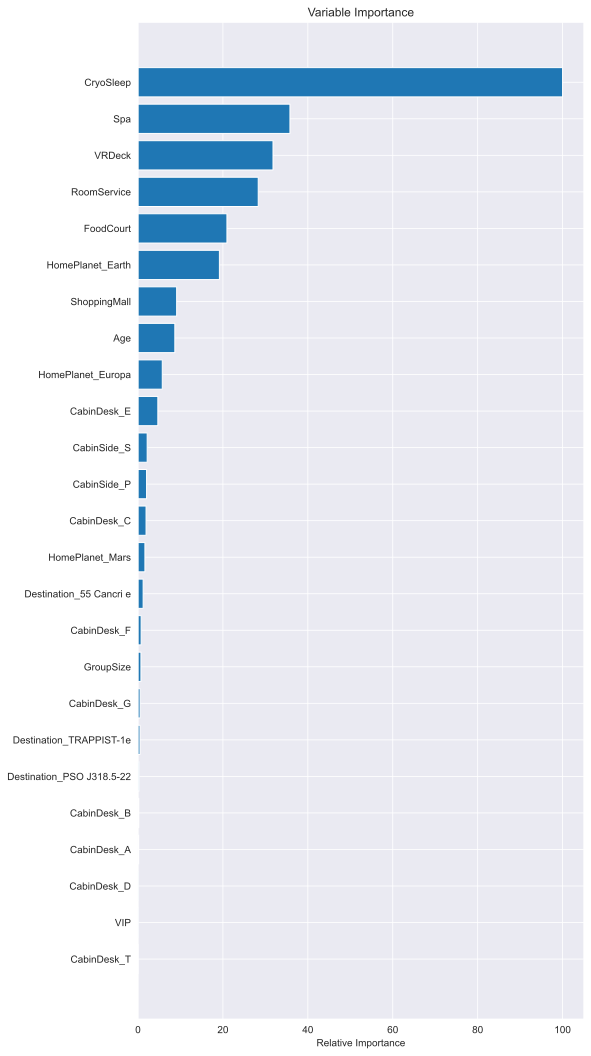

In [12]:
plot_feature_importance(GradientBoostingClassifier(), train_df, transported)

In [17]:
import model_fitting as mf

In [3]:
sys.path

['/Users/ssv/Library/Application Support/JetBrains/Toolbox/apps/PyCharm-P/ch-0/222.4459.20/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug',
 '/Users/ssv/Library/Application Support/JetBrains/Toolbox/apps/PyCharm-P/ch-0/222.4459.20/PyCharm.app/Contents/plugins/python/helpers/pydev',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/Code',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/Code',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/envs/lib/python310.zip',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/envs/lib/python3.10',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/envs/lib/python3.10/lib-dynload',
 '',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/envs/lib/python3.10/site-packages',
 '/Users/ssv/TestProj/ML/Spaceship_Titanic/envs/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-macosx-10.9-x86_64.egg',
 '/Users/ssv/ssv_modules/models_fitting']

In [9]:
import sys
sys.path.append('/Users/ssv/ssv_modules/models_fitting')

In [10]:
import scoring

In [10]:
scoring.pr('aaaaaaa')


aaaaaaa


In [15]:
np.random.seed(0)

In [11]:
scoring.cross_val(train_df, transported, n_splits=5)

          KNeighborsClassifier: mean accuracy =76.65%;standard deviation =0.84%; 
                           SVC: mean accuracy =78.59%;standard deviation =1.03%; 
                    GaussianNB: mean accuracy =74.23%;standard deviation =0.77%; 
        RandomForestClassifier: mean accuracy =78.52%;standard deviation =0.31%; 
          ExtraTreesClassifier: mean accuracy =77.38%;standard deviation =0.33%; 
        DecisionTreeClassifier: mean accuracy =73.08%;standard deviation =1.13%; 
    GradientBoostingClassifier: mean accuracy =80.08%;standard deviation =0.16%; 
            AdaBoostClassifier: mean accuracy =78.72%;standard deviation =0.90%; 
HistGradientBoostingClassifier: mean accuracy =80.17%;standard deviation =0.74%; 
             BaggingClassifier: mean accuracy =77.42%;standard deviation =1.81%; 


,Model_Name,Mean_Accuracy,Standard_Deviation
0,KNeighborsClassifier,0.766479,0.008418
1,SVC,0.785921,0.010268
2,GaussianNB,0.742321,0.007736
3,RandomForestClassifier,0.785230,0.003087
4,ExtraTreesClassifier,0.773841,0.003319
5,DecisionTreeClassifier,0.730818,0.011282
6,GradientBoostingClassifier,0.800759,0.001637
7,AdaBoostClassifier,0.787185,0.008976
8,HistGradientBoostingClassifier,0.801681,0.007442
9,BaggingClassifier,0.774181,0.018075


In [ ]:
no_important_columns = [
                        'CabinDesk_T', 
                        'CabinDesk_D', 
                        'VIP',
                        'CabinDesk_A',
                        'Destination_PSO J318.5-22', 
                        'CabinDesk_B', 
                        'Destination_TRAPPIST-1e',
                        'CabinDesk_G'
                       ]

In [ ]:
train_df.drop(no_important_columns, axis = 1, inplace=True)
test_df.drop(no_important_columns, axis = 1, inplace=True)

In [ ]:
plot_feature_importance(GradientBoostingClassifier(), train_df, transported)

## ------------------------------------------------------------------------------------------------------------

# MODEL


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [ ]:
model = GradientBoostingClassifier(n_estimators=100, max_features='auto', learning_rate=0.1, 
                                                              max_depth=4, random_state=0)

model.fit(train_df, transported)  
prediction = model.predict(test_df)  

## Score: 0.80547

In [ ]:
submission_df['Transported'] = prediction
submission_df['Transported'] = submission_df['Transported'].apply(lambda r: True if r == 1 else False)

submission_df.to_csv('007_GB.csv', index=False)